# Data Cleaning

I've collected data from the top 10,000 popular movies ranging from summer 2010 to summer 2020 on IMDB using web scraping and combined this with budget and revenue data for these movies collected from TMDB using their API. 

Next, I'll get a sense of what the data looks like.

## Import Libraries and Data

In [1]:
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format

In [2]:
df = pd.read_pickle("./movie_data.pkl")

## Explore and Clean Data

First, I want to make sure the shape of the dataframe is what I would expect. I collected 10,000 movies and for each I grabbed the following information.
* `title`
* `mpaa_rating`
* `runtime`
* `genre`
* `star_rating` - This is the rating the movie has on IMDB out of 10.
* `budget`
* `revenue`

As such, I expect my dataframe to have 10,000 rows and 7 columns.

In [3]:
df.shape

(10000, 7)

Great. Now I want to see what this dataframe looks like.

In [4]:
df.head()

,title,mpaa_rating,runtime,genre,star_rating,budget,revenue
0,Cats,PG,110 min,"\nComedy, Drama, Family",2.8,95000000.00,73515024.00
1,Promising Young Woman,R,113 min,"\nComedy, Crime, Drama",6.1,0.00,0.00
2,Inheritance,NaN,111 min,"\nDrama, Mystery, Thriller",5.5,0.00,0.00
3,The Lie,R,97 min,"\nCrime, Drama, Horror",5.7,0.00,0.00
4,The Gentlemen,R,113 min,"\nAction, Comedy, Crime",7.9,22000000.00,114996853.00


That looks correct. Next, I want to look at my columns more in depth.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
title          10000 non-null object
mpaa_rating    7237 non-null object
runtime        9914 non-null object
genre          9998 non-null object
star_rating    9981 non-null object
budget         9922 non-null float64
revenue        9922 non-null float64
dtypes: float64(2), object(5)
memory usage: 547.0+ KB


### Fixing Data Types

It looks like two of my columns are not the right data type; `star_rating` should be a float, and `runtime` should be an integer. The first will be an easy fix, but since `runtime` contains both numbers and text, I'll need to turn it into a string, strip the text I don't want, and then turn the column into type int. 

Before I can do this to `runtime`, I'll have to clean the null values, since I can't turn a null value into a string. Since I'm missing this data point for only 91 out of my 10,000 movies, I'll go ahead and just remove these.

In [6]:
df.dropna(subset=['runtime'], inplace=True)

In [7]:
df['runtime'].isna().sum()

0

Now I can correct the data types of both `star_rating` and `runtime`.

In [8]:
df['runtime'] = df['runtime'].astype(str)
df['runtime'] = df['runtime'].apply(lambda x: x.rstrip(' min'))
df['runtime'] = df['runtime'].astype(int)

In [9]:
df.rename(columns={'runtime': 'runtime_in_mins'}, inplace=True)

In [10]:
df['star_rating'] = df['star_rating'].astype(float)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9914 entries, 0 to 9999
Data columns (total 7 columns):
title              9914 non-null object
mpaa_rating        7227 non-null object
runtime_in_mins    9914 non-null int64
genre              9913 non-null object
star_rating        9903 non-null float64
budget             9857 non-null float64
revenue            9857 non-null float64
dtypes: float64(3), int64(1), object(3)
memory usage: 619.6+ KB


### Binning `mpaa_rating` Values

Next, I'll look at the value count of my categorical column `mpaa_rating`.

In [12]:
df['mpaa_rating'].value_counts(dropna=False)

NaN          2687
R            2428
Not Rated    1999
PG-13        1122
TV-MA         491
PG            459
Unrated       300
TV-14         280
TV-PG          75
G              37
TV-G           15
TV-Y7           8
NC-17           5
M               4
TV-Y            2
MA-17           1
18              1
Name: mpaa_rating, dtype: int64

Immediately I notice that I have 3 different categories that should be combined into one: NA, 'Not Rated', and 'Unrated'.

In [13]:
df['mpaa_rating'].fillna('Not Rated', inplace=True)
df['mpaa_rating'].replace('Unrated', 'Not Rated', inplace=True)

In [14]:
df['mpaa_rating'].value_counts(dropna=False)

Not Rated    4986
R            2428
PG-13        1122
TV-MA         491
PG            459
TV-14         280
TV-PG          75
G              37
TV-G           15
TV-Y7           8
NC-17           5
M               4
TV-Y            2
18              1
MA-17           1
Name: mpaa_rating, dtype: int64

I still have a lot of different categories here. For my analysis, I really only care about what type of audience a movie is catering to, not the specific rating. As such, I'm going to combine the categories as follows:
* 'All Ages' - 'G' and 'TV-G'
* 'Children' - 'TV-Y' and 'TV-Y7'
* 'Pre-teen+'  - 'PG' and 'TV-PG'
* 'Teen+' - 'PG-13' and 'TV-14'
* 'Adult' - 'R', 'NC-17', 'M', 'MA-17', '18' and 'TV-MA'

I'll also rename the column to be `intended_audience`.

In [15]:
df['mpaa_rating'].replace(['G', 'TV-G'], 'All Ages', inplace=True)
df['mpaa_rating'].replace(['TV-Y', 'TV-Y7'], 'Children', inplace=True)
df['mpaa_rating'].replace(['PG', 'TV-PG'], 'Pre-teen+', inplace=True)
df['mpaa_rating'].replace(['PG-13', 'TV-14'], 'Teen+', inplace=True)
df['mpaa_rating'].replace(['R', 'NC-17', 'M', 'MA-17', '18', 'TV-MA'], 'Adult', inplace=True)

In [16]:
df.rename(columns={'mpaa_rating': 'intended_audience'}, inplace=True)

In [17]:
df['intended_audience'].value_counts(dropna=False)

Not Rated    4986
Adult        2930
Teen+        1402
Pre-teen+     534
All Ages       52
Children       10
Name: intended_audience, dtype: int64

### Removing Leftover Null Values

Another column that could use some quick cleaning is `genre`, which currently only has one null value. I'll fill that with "No Genre" to keep it as a string, and remove the leading newline character.

In [18]:
df['genre'].fillna("No Genre", inplace=True)
df['genre'] = df['genre'].apply(lambda x: x.lstrip('\n'))

The `star_rating` column also has 8 null values. I'll just remove these rows from my dataset since it will still leave me with plenty of data points to analyze.

In [19]:
df.dropna(subset=['star_rating'], inplace=True)

In [20]:
df.shape

(9903, 7)

### Creating a Finances Dataframe

From the table, I see that some budget and revenue numbers are listed as 0. When analyzing movie budgets and revenue, I only want to analyze movies which have these data points. I'll create a new dataframe `df_finances` which I can use when analyzing the finances of the movies. 

To start off, I'll see how many 0 values I have for these.

In [21]:
df.isin([0]).sum()

title                   0
intended_audience       0
runtime_in_mins         0
genre                   0
star_rating             0
budget               6809
revenue              6945
dtype: int64

In [22]:
df_finances = df[df['revenue'] != 0] 
df_finances = df_finances[df_finances['budget'] != 0]
df_finances.dropna(subset=['revenue', 'budget'], inplace=True)

To this dataframe, I want to add a profit column as a combination of the budget and revenue columns.

In [23]:
df_finances['profit'] = df_finances['revenue'] - df_finances['budget']

In [24]:
df_finances.reset_index(drop=True, inplace=True)

In [25]:
df_finances.head()

,title,intended_audience,runtime_in_mins,genre,star_rating,budget,revenue,profit
0,Cats,Pre-teen+,110,"Comedy, Drama, Family",2.80,95000000.00,73515024.00,-21484976.00
1,The Gentlemen,Adult,113,"Action, Comedy, Crime",7.90,22000000.00,114996853.00,92996853.00
2,Once Upon a Time... In Hollywood,Adult,161,"Comedy, Drama",7.60,95000000.00,374251247.00,279251247.00
3,The Invisible Man,Adult,124,"Horror, Mystery, Sci-Fi",7.10,7000000.00,130234661.00,123234661.00
4,Knives Out,Teen+,130,"Comedy, Crime, Drama",7.90,40000000.00,309232797.00,269232797.00


Next, I'd like to see the statistics for these finances.

In [26]:
df_finances.describe()

,runtime_in_mins,star_rating,budget,revenue,profit
count,2077.00,2077.00,2077.00,2077.00,2077.00
mean,111.61,6.44,39014047.49,126147488.34,87133440.85
std,19.73,1.00,51486614.89,234047903.40,196566000.20
min,63.00,1.40,1.00,4.00,-165710090.00
25%,97.00,5.80,7000000.00,7200000.00,-1195000.00
50%,108.00,6.50,20000000.00,39407616.00,16391084.00
75%,123.00,7.10,45000000.00,130482868.00,84281051.00
max,321.00,8.80,380000000.00,2797800564.00,2441800564.00


To remove outliers, I'll look at a boxplot and remove any elements which fall outside of the fences. Since I'm just analyzing this data to answer business questions, I don't need to worry about how removing this data would affect a model's predictions.

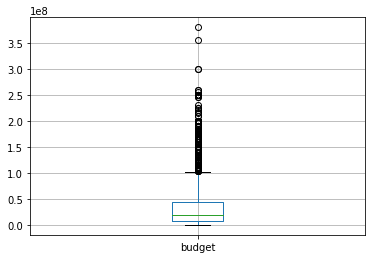

In [44]:
df_finances.boxplot(column='budget')

In [28]:
q1 = df_finances['budget'].quantile(0.25)
q3 = df_finances['budget'].quantile(0.75)
iqr = q3 - q1
fence_low = q1 - (1.5*iqr)
fence_high = q3 + (1.5*iqr)
# number of outliers
df_finances[(df_finances['budget'] < fence_low) | (df_finances['budget'] > fence_high)].shape[0]

231

Since only 231 movies are classified as outliers, I still keep 88% of my data points.

In [29]:
df_finances = df_finances[(df_finances['budget'] >= fence_low) & (df_finances['budget'] <= fence_high)]

In [30]:
df_finances.boxplot(column='budget')

In [45]:
#TODO remove outliers for revenue

In [31]:
df_finances.shape

(2077, 8)

Looks like that leaves me with 2,117 movie details to use for analyzing popular movie finances.

### Creating a Genre Dataframe

The genre column value for each movie is a list of the genres they belong to. My goal for these is to see which genres provide higher profit and ratings on average, as well as their average runtimes. To get this information, I'm going to create a new dataframe with every row being a genre, and the columns being `avg_rating`, `avg_runtime` and `avg_profit`.

To start, I'll need to collect a count of how many movies fit into each individual genre. I'll use the `df_finances` dataframe for this, since I need revenue and budget values to be valid in order to calculate the profit.

In [32]:
genre_dict = {}
for genres in df_finances['genre']: 
    for genre in genres.split(','):
        genre = genre.strip()
        if genre in genre_dict:
            genre_dict[genre] += 1
        else:
            genre_dict[genre] = 1

Now I'll make a new dataframe `genre_df` with a column of genres and a column counting how many movies fell into that genre.

In [33]:
genre_df_dict = {'genre': list(genre_dict.keys()), 'count': list(genre_dict.values())}
genre_df = pd.DataFrame(genre_df_dict)

In [34]:
genre_df.head()

,genre,count
0,Comedy,688
1,Drama,1118
2,Family,105
3,Action,680
4,Crime,345


Looks great, now I'll add the rating, runtime and profit columns.

In [35]:
unique_genres = list(genre_df['genre'].values)
genre_rating_dict = {}
for index, row in df_finances.iterrows():
    for genre in unique_genres:
        if genre in row['genre']:
            rating = row['star_rating']
            if genre in genre_rating_dict:
                genre_rating_dict[genre] += rating
            else:
                genre_rating_dict[genre] = rating

genre_df['rating_sum'] = list(genre_rating_dict.values())
genre_df['avg_rating'] = round(genre_df['rating_sum']/genre_df['count'], 1)
genre_df.drop(columns=['rating_sum'], inplace=True)

In [36]:
genre_df.head()

,genre,count,avg_rating
0,Comedy,688,6.30
1,Drama,1118,6.70
2,Family,105,6.20
3,Action,680,6.40
4,Crime,345,6.50


In [37]:
#TODO: optimize this loop!

In [38]:
genre_runtime_dict = {}
for index, row in df_finances.iterrows():
    for genre in unique_genres:
        if genre in row['genre']:
            runtime = row['runtime_in_mins']
            if genre in genre_runtime_dict:
                genre_runtime_dict[genre] += runtime
            else:
                genre_runtime_dict[genre] = runtime

genre_df['runtime_sum'] = list(genre_runtime_dict.values())
genre_df['avg_runtime_in_mins'] = round(genre_df['runtime_sum']/genre_df['count'])
genre_df.drop(columns=['runtime_sum'], inplace=True)
genre_df['avg_runtime_in_mins'] = genre_df['avg_runtime_in_mins'].astype(int)

In [39]:
genre_df.head()

,genre,count,avg_rating,avg_runtime_in_mins
0,Comedy,688,6.30,105
1,Drama,1118,6.70,116
2,Family,105,6.20,104
3,Action,680,6.40,116
4,Crime,345,6.50,112


In [40]:
genre_profit_dict = {}
for index, row in df_finances.iterrows():
    for genre in unique_genres:
        if genre in row['genre']:
            profit = row['profit']
            if genre in genre_profit_dict:
                genre_profit_dict[genre] += profit
            else:
                genre_profit_dict[genre] = profit

genre_df['profit_sum'] = list(genre_profit_dict.values())
genre_df['avg_profit'] = round(genre_df['profit_sum']/genre_df['count'])
genre_df.drop(columns=['profit_sum'], inplace=True)

In [41]:
genre_df.head()

,genre,count,avg_rating,avg_runtime_in_mins,avg_profit
0,Comedy,688,6.30,105,83267043.00
1,Drama,1118,6.70,116,44550327.00
2,Family,105,6.20,104,130868125.00
3,Action,680,6.40,116,135505743.00
4,Crime,345,6.50,112,37286289.00


### Store Cleaned Dataframes

In [42]:
df.to_pickle("./cleaned_movie_data.pkl")
df_finances.to_pickle("./movie_finance_data.pkl")
genre_df.to_pickle("./movie_genre_data.pkl")